In [1]:
__file__ = "run_fulll.ipynb"

In [2]:
"""Training script for training the weather forecasting model"""
import json
import os
import sys

sys.path.append(os.path.dirname(os.path.realpath(__file__)) + "/../")

from glob import glob
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import xarray as xr
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from graph_weather import GraphWeatherForecaster
from graph_weather.data import const
from graph_weather.models.losses import NormalizedMSELoss
import matplotlib.pyplot as plt


class XrDataset(Dataset):
    def __init__(self, file_name):
        super().__init__()

        self.data = xr.open_dataset(file_name, engine="netcdf4")

    def __len__(self):
        return len(self.data.time) - 1

    def __getitem__(self, idx):
        # start_idx = np.random.randint(0, len(self.data.time) - 1)
        data = self.data.isel(time=slice(idx, idx + 2))
        start = data.isel(time=0)
        end = data.isel(time=1)

        # if inter_data is not None and start != inter_data:
        #     start = inter_data
        #     end = data.isel(time=0)
        # elif start == inter_data:
        #     start = data.isel(time = 0)
        #     end = data.isel(time = 1)
        # else:
        #     start = data.isel(time=0)
        #     try:
        #         end = data.isel(time=1)
        #     except IndexError:
        #         inter_data = data.isel(time=0)

        # Stack the data into a large data cube
        input_data = np.stack(
            [
                (start[f"{var}"].values - const.FORECAST_MEANS[f"{var}"])
                / (const.FORECAST_STD[f"{var}"] + 0.0001)
                for var in start.data_vars
            ],
        )
        # input_data = np.stack(
        #     [(start[f"{var}"].values) for var in start.data_vars], axis=-1
        # )
        input_data = np.nan_to_num(input_data)

        assert not np.isnan(input_data).any()
        output_data = np.stack(
            [
                (end[f"{var}"].values - const.FORECAST_MEANS[f"{var}"])
                / (const.FORECAST_STD[f"{var}"] + 0.0001)
                for var in end.data_vars
            ]
        )
        # output_data = np.stack(
        #     [(end[f"{var}"].values) for var in end.data_vars], axis=-1
        # )
        output_data = np.nan_to_num(output_data)
        assert not np.isnan(output_data).any()
        transform = transforms.Compose([transforms.ToTensor()])
        # Normalize now
        return (
            transform(input_data)
            .transpose(0, 2)
            .transpose(1, 2)
            .reshape(-1, input_data.shape[0]),
            transform(input_data)
            .transpose(0, 2)
            .transpose(1, 2)
            .reshape(-1, input_data.shape[0]),
        )


data = xr.open_dataset(
    "../graph_weather/data/MERRA2_400.inst3_3d_asm_Nv.20230701_merged.nc",
    engine="netcdf4",
)
# print(data)
# print("Done coarsening")
# meshgrid takes in the lat and lon values, creates the arrays of every single latitude with the length of every single longitude, np.array reshapes it to get a matrix
# which contains the lat lon co-related values, eg. 90*180, 90*179.375 etc.
lat_lons = np.array(np.meshgrid(data.lat.values, data.lon.values)).T.reshape(-1, 2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "mps" if torch.backends.mps.is_available() else "cpu"
# Get the variance of the variables
feature_variances = []
for var in data.data_vars:
    feature_variances.append(const.FORECAST_DIFF_STD[var] ** 2)
criterion = NormalizedMSELoss(
    lat_lons=lat_lons, feature_variance=feature_variances, device=device
).to(device)
means = []
# dataset = DataLoader(XrDataset(), batch_size=1)
# files_dataloader = DataLoader(FileDataset("graph_weather/data/train_data"), batch_size = 1)
model = GraphWeatherForecaster(lat_lons, feature_dim=65, num_blocks=6).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.00001)
print("Done Setup")
import time

train_files = glob("../graph_weather/data/train_data/*.nc", recursive=True)
val_files = glob("../graph_weather/data/val_data/*.nc", recursive=True)
running_loss, running_val_loss = [], []
for epoch in range(10):  # loop over the dataset multiple times
    model.train()
    start = time.time()
    inter_data = None
    running_loss_files = []
    running_val_loss_files = []
    for name in train_files:
        dataset = DataLoader(XrDataset(name), batch_size=1)

        # print(f"Start Epoch: {epoch+1}")
        for i, data in tqdm(enumerate(dataset), total=len(dataset), leave=False):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss_files.append(loss.item())
        print(f"{epoch + 1} training_loss: {np.mean(running_loss_files)}")

    model.eval()
    for name in val_files:
        dataset = DataLoader(XrDataset(name), batch_size=1)

        # print(f"Start Epoch: {epoch+1}")
        for i, data in tqdm(enumerate(dataset), total=len(dataset), leave=False):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # forward + backward + optimize
            outputs = model(inputs)

            val_loss = criterion(outputs, labels)

            # print statistics
            running_val_loss_files.append(val_loss.item())
            # print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i + 1):.3f}")
        print(f"{epoch + 1} validation_loss: {np.mean(running_val_loss_files)}")

    running_loss.append(np.mean(running_loss_files))
    running_val_loss.append(np.mean(running_val_loss_files))
end = time.time()
print(f"Time: {end - start} sec")

/Users/vgaur/miniconda3/envs/graph-weather/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Done Setup


1 training_loss: 0.004777925055740135


1 training_loss: 0.0035667667065614034


1 training_loss: 0.002953373339204561


1 training_loss: 0.0025725730478630532


1 training_loss: 0.0022999511166874854


1 training_loss: 0.0020878388299717613


1 training_loss: 0.0019152120423351167


1 training_loss: 0.0017729380903931866


1 training_loss: 0.001653888115903274


1 training_loss: 0.001552786643982732


1 training_loss: 0.0014656599446248215


1 training_loss: 0.0013897920559559549


1 training_loss: 0.0013230567290140622


1 training_loss: 0.001263726949014663


1 training_loss: 0.0012105685137655763


1 training_loss: 0.0011626746329836482


1 training_loss: 0.0011192934163024321


1 training_loss: 0.0010797653036812942


1 validation_loss: 0.0003986027233103024


1 validation_loss: 0.0003985742888679462


1 validation_loss: 0.000398552846274383


1 validation_loss: 0.00039855581313271875


1 validation_loss: 0.0003985551984182426


1 validation_loss: 0.0003985464011618335


1 validation_loss: 0.0003985523523012062


1 validation_loss: 0.00039854718436669955


2 training_loss: 0.000391638875173937


2 training_loss: 0.0003839786659227684


2 training_loss: 0.00037649275396861847


2 training_loss: 0.0003692042841326578


2 training_loss: 0.00036209815963437515


2 training_loss: 0.00035518025522053776


2 training_loss: 0.0003484539867008143


2 training_loss: 0.0003419011752287458


2 training_loss: 0.00033550286648928056


2 training_loss: 0.000329253075428174


2 training_loss: 0.00032314604190601545


2 training_loss: 0.00031716535782574544


2 training_loss: 0.00031131140521220904


2 training_loss: 0.00030557669824516704


2 training_loss: 0.00029995579915564685


2 training_loss: 0.0002944447508395699


2 training_loss: 0.0002890402841735866


2 training_loss: 0.00028373691228417944


2 validation_loss: 0.00018858677815712457


2 validation_loss: 0.00018858780406714817


2 validation_loss: 0.00018858088116671535


2 validation_loss: 0.00018858111226498813


2 validation_loss: 0.00018858380665603492


2 validation_loss: 0.0001885852162515567


2 validation_loss: 0.00018858944828508003


2 validation_loss: 0.00018858784954188325


3 training_loss: 0.00018486245452160283


3 training_loss: 0.0001806375543570279


3 training_loss: 0.000176474784633943


3 training_loss: 0.0001723847266735642


3 training_loss: 0.00016826033741900964


3 training_loss: 0.00016397964957702373


3 training_loss: 0.0001597471187147787


3 training_loss: 0.0001556071412258981


3 training_loss: 0.00015156524184729077


3 training_loss: 0.0001476208169021577


3 training_loss: 0.00014377477300631537


3 training_loss: 0.00014002416035163194


3 training_loss: 0.0001363648408077207


3 training_loss: 0.00013279374311701869


3 training_loss: 0.0001293086600656222


3 training_loss: 0.00012590554557131588


3 training_loss: 0.00012258513480377923


3 training_loss: 0.00011934779133067451


3 validation_loss: 6.1497552711184e-05


3 validation_loss: 6.149787908985413e-05


3 validation_loss: 6.149351524765647e-05


3 validation_loss: 6.149399294892126e-05


3 validation_loss: 6.149609273831759e-05


3 validation_loss: 6.149497009270515e-05


3 validation_loss: 6.149779549058603e-05


3 validation_loss: 6.149568564848908e-05


4 training_loss: 5.943864120386674e-05


4 training_loss: 5.7143500401122894e-05


4 training_loss: 5.491201972333892e-05


4 training_loss: 5.275975010070917e-05


4 training_loss: 5.0682237633736805e-05


4 training_loss: 4.867969636550351e-05


4 training_loss: 4.67334947624833e-05


4 training_loss: 4.483865586735192e-05


4 training_loss: 4.301586537506424e-05


4 training_loss: 4.127067550143693e-05


4 training_loss: 3.960670610113438e-05


4 training_loss: 3.8020516924353574e-05


4 training_loss: 3.651045807311055e-05


4 training_loss: 3.507444207385486e-05


4 training_loss: 3.37099830912415e-05


4 training_loss: 3.241219042950304e-05


4 training_loss: 3.117944530810341e-05


4 training_loss: 3.0008654094773294e-05


4 validation_loss: 9.396304968894193e-06


4 validation_loss: 9.396705146562973e-06


4 validation_loss: 9.39561674126058e-06


4 validation_loss: 9.395853404774762e-06


4 validation_loss: 9.39746311944743e-06


4 validation_loss: 9.397082651828117e-06


4 validation_loss: 9.398992228760071e-06


4 validation_loss: 9.398020373347598e-06


5 training_loss: 8.894887676953139e-06


5 training_loss: 8.361182153748814e-06


5 training_loss: 7.858518269391165e-06


5 training_loss: 7.391412834424825e-06


5 training_loss: 6.957736695767381e-06


5 training_loss: 6.556253419191871e-06


5 training_loss: 6.184504455836295e-06


5 training_loss: 5.8416745706121475e-06


5 training_loss: 5.524955090622247e-06


5 training_loss: 5.231228975130112e-06


5 training_loss: 4.960532129638074e-06


5 training_loss: 4.709978604805223e-06


5 training_loss: 4.478337659448088e-06


5 training_loss: 4.264452395453153e-06


5 training_loss: 4.0670646090542764e-06


5 training_loss: 3.883955857629319e-06


5 training_loss: 3.7143755332731453e-06


5 training_loss: 3.557278625795868e-06


5 validation_loss: 8.27718947350929e-07


5 validation_loss: 8.288826255206264e-07


5 validation_loss: 8.278943553142156e-07


5 validation_loss: 8.27647556077084e-07


5 validation_loss: 8.28622920120584e-07


5 validation_loss: 8.287178175015427e-07


5 validation_loss: 8.301863739948853e-07


5 validation_loss: 8.298090057629841e-07


6 training_loss: 7.842557059640447e-07


6 training_loss: 7.479961782662161e-07


6 training_loss: 7.106115920881469e-07


6 training_loss: 6.773540580492668e-07


6 training_loss: 6.463157985438427e-07


6 training_loss: 6.184286982196292e-07


6 training_loss: 5.930670921798639e-07


6 training_loss: 5.706950828100941e-07


6 training_loss: 5.504744901177869e-07


6 training_loss: 5.313283452323958e-07


6 training_loss: 5.146069823199055e-07


6 training_loss: 4.989205411983935e-07


6 training_loss: 4.845320486910478e-07


6 training_loss: 4.715586968888267e-07


6 training_loss: 4.5985996301905767e-07


6 training_loss: 4.4888686088841367e-07


6 training_loss: 4.3866447830654226e-07


6 training_loss: 4.293000617710479e-07


6 validation_loss: 2.667804242914177e-07


6 validation_loss: 2.6830600623790293e-07


6 validation_loss: 2.6729034630079695e-07


6 validation_loss: 2.672540375669996e-07


6 validation_loss: 2.680726319275501e-07


6 validation_loss: 2.682767021020655e-07


6 validation_loss: 2.693844967139665e-07


6 validation_loss: 2.693648184504127e-07


7 training_loss: 2.6090995675076556e-07


7 training_loss: 2.614163524380534e-07


7 training_loss: 2.589404608616384e-07


7 training_loss: 2.571468290365634e-07


7 training_loss: 2.542327138144174e-07


7 training_loss: 2.517175009383469e-07


7 training_loss: 2.493128894624236e-07


7 training_loss: 2.474898559106415e-07


7 training_loss: 2.458232852549127e-07


7 training_loss: 2.4359631802488887e-07


7 training_loss: 2.4199636663389036e-07


7 training_loss: 2.4019878454493793e-07


7 training_loss: 2.3834296408060234e-07


7 training_loss: 2.3672750131129074e-07


7 training_loss: 2.353966082290797e-07


7 training_loss: 2.3392006338290067e-07


7 training_loss: 2.3241333772549458e-07


7 training_loss: 2.3106280396617992e-07


7 validation_loss: 2.0721820094747402e-07


7 validation_loss: 2.0890220144208017e-07


7 validation_loss: 2.0780378493089388e-07


7 validation_loss: 2.0774919004143806e-07


7 validation_loss: 2.08436853605625e-07


7 validation_loss: 2.0865175035364052e-07


7 validation_loss: 2.0953781179101422e-07


7 validation_loss: 2.096354277471489e-07


8 training_loss: 2.036506024134204e-07


8 training_loss: 2.051928709485245e-07


8 training_loss: 2.039672635657466e-07


8 training_loss: 2.0368161760383634e-07


8 training_loss: 2.0228105849387898e-07


8 training_loss: 2.010895323272572e-07


8 training_loss: 1.9998244497122758e-07


8 training_loss: 1.992070536463838e-07


8 training_loss: 1.9847617689749082e-07


8 training_loss: 1.971931362325969e-07


8 training_loss: 1.963786439552217e-07


8 training_loss: 1.9538373949433748e-07


8 training_loss: 1.9429417379497253e-07


8 training_loss: 1.9332538922104243e-07


8 training_loss: 1.926512138219377e-07


8 training_loss: 1.9179146106194723e-07


8 training_loss: 1.9088974676581246e-07


8 training_loss: 1.9009996630111058e-07


8 validation_loss: 1.7579185599255913e-07


8 validation_loss: 1.7741450619723764e-07


8 validation_loss: 1.7634819336026773e-07


8 validation_loss: 1.7629836079890993e-07


8 validation_loss: 1.768631883740974e-07


8 validation_loss: 1.771202927817025e-07


8 validation_loss: 1.7788360912154345e-07


8 validation_loss: 1.779998924129294e-07


9 training_loss: 1.731673973738777e-07


9 training_loss: 1.7465303666800276e-07


9 training_loss: 1.7351340394119083e-07


9 training_loss: 1.7343347329707675e-07


9 training_loss: 1.72346923526285e-07


9 training_loss: 1.7142028410500557e-07


9 training_loss: 1.7059756644079133e-07


9 training_loss: 1.7007302563091082e-07


9 training_loss: 1.695485096094657e-07


9 training_loss: 1.6854731878116321e-07


9 training_loss: 1.6795660269213226e-07


9 training_loss: 1.6719180926489095e-07


9 training_loss: 1.6634919856247446e-07


9 training_loss: 1.6556993584776584e-07


9 training_loss: 1.6507855410249508e-07


9 training_loss: 1.6441531615539263e-07


9 training_loss: 1.6370896965216298e-07


9 training_loss: 1.6309459309713784e-07


9 validation_loss: 1.52178176092223e-07


9 validation_loss: 1.5345498484618603e-07


9 validation_loss: 1.5252862253657354e-07


9 validation_loss: 1.5251235855170568e-07


9 validation_loss: 1.529827682946104e-07


9 validation_loss: 1.5321135090776545e-07


9 validation_loss: 1.5384671894712574e-07


9 validation_loss: 1.5394055858613293e-07


10 training_loss: 1.4986666282571344e-07


10 training_loss: 1.5115990846327675e-07


10 training_loss: 1.5004217229510514e-07


10 training_loss: 1.500498742400071e-07


10 training_loss: 1.49157277665576e-07


10 training_loss: 1.4838940286056511e-07


10 training_loss: 1.4769480803899607e-07


10 training_loss: 1.473124395801051e-07


10 training_loss: 1.468853793446056e-07


10 training_loss: 1.460547480292007e-07


10 training_loss: 1.455950231142102e-07


10 training_loss: 1.4496973881656621e-07


10 training_loss: 1.4427972026389177e-07


10 training_loss: 1.4362924012945712e-07


10 training_loss: 1.4323727338619177e-07


10 training_loss: 1.4269148148774287e-07


10 training_loss: 1.4210738496682602e-07


10 training_loss: 1.4158709856048286e-07


10 validation_loss: 1.3282869864334706e-07


10 validation_loss: 1.3384230003664145e-07


10 validation_loss: 1.330402509005407e-07


10 validation_loss: 1.3304868013668575e-07


10 validation_loss: 1.3341866633709287e-07


10 validation_loss: 1.3361565382161816e-07


10 validation_loss: 1.3414277521879201e-07


10 validation_loss: 1.342124230165252e-07
Time: 6184.403642177582 sec


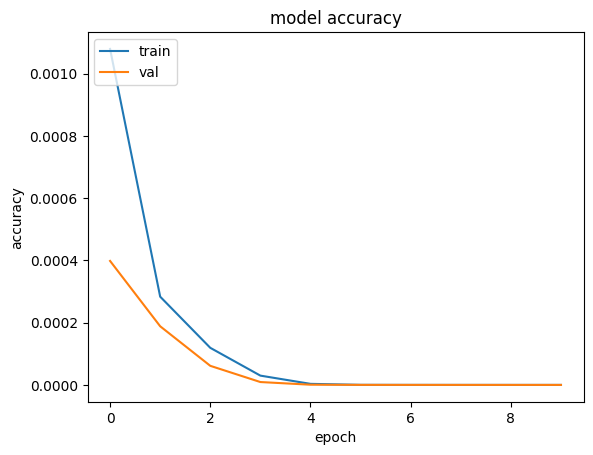

In [3]:
plt.plot(running_loss)
plt.plot(running_val_loss)
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
# plt.savefig("openweather_20epochs_merra_batch_2.png")
# plt.show()

In [6]:
test_dir = glob("../graph_weather/data/test_data/*.nc", recursive=True)
test_dir

['../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230718_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230720_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230726_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230719_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230721_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230722_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230717_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230724_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230723_merged.nc',
 '../graph_weather/data/test_data/MERRA2_400.inst3_3d_asm_Nv.20230725_merged.nc']

In [7]:
dataset = DataLoader(XrDataset(test_dir[0]), batch_size= 7)

In [12]:
items = iter(dataset)
inputs, labels = next(items)

In [17]:
inputs, labels = inputs.to(device), labels.to(device)
outputs_test = model(inputs)
diff_test = labels - outputs_test

Text(0.5, 1.0, 'Difference in actual output and prediction')

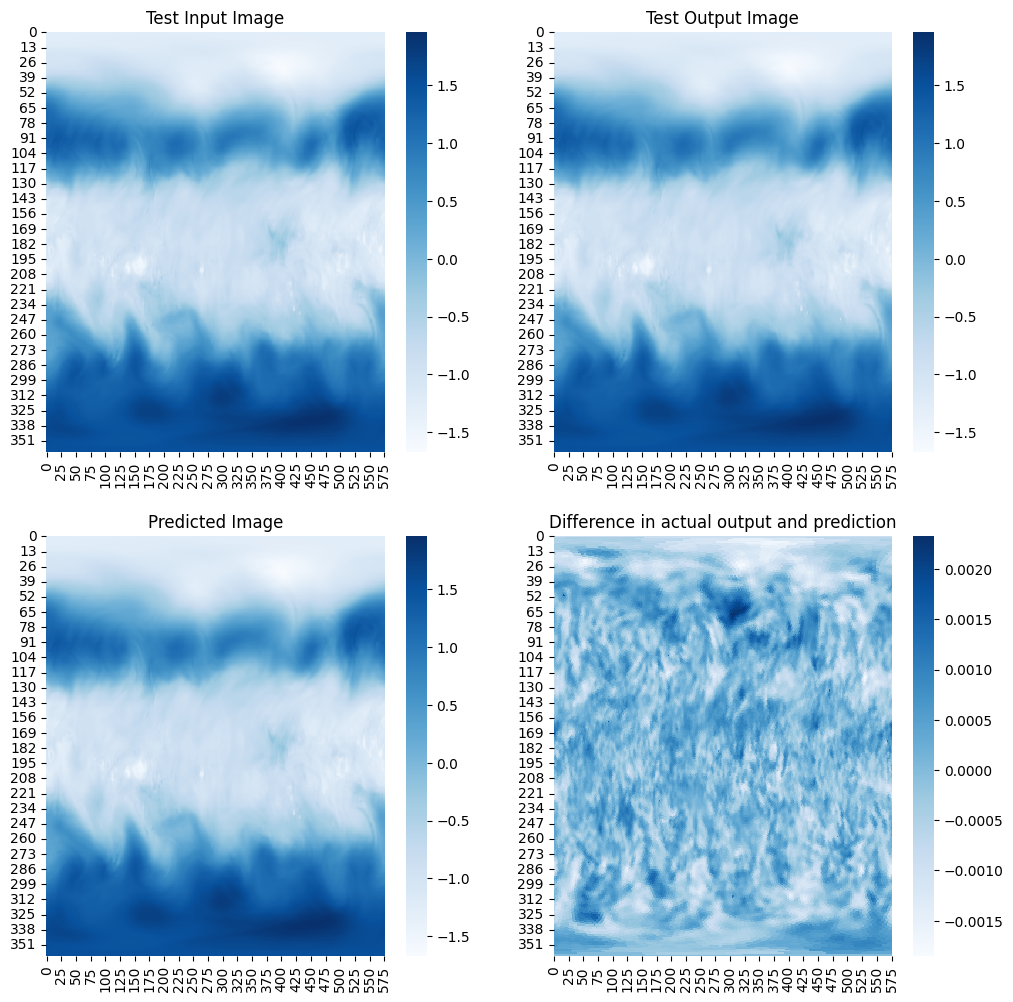

In [43]:
fig1, ax1 = plt.subplots(2, 2, figsize=(12, 12))
sns.heatmap(torch.reshape(inputs, (1, 361, 576, 65))[0, :, :, 27], cbar = True, cmap = 'Blues', ax = ax1[0][0])
ax1[0][0].set_title("Test Input Image")

sns.heatmap(torch.reshape(labels, (1, 361, 576, 65))[0, :, :, 27], cbar = True, cmap = 'Blues', ax = ax1[0][1])
ax1[0][1].set_title("Test Output Image")

sns.heatmap(torch.reshape(outputs_test, (1, 361, 576, 65)).detach().numpy()[0, :, :, 27], cmap = 'Blues', cbar= True, ax = ax1[1][0])
ax1[1][0].set_title("Predicted Image")

sns.heatmap(torch.reshape(diff_test, (1, 361, 576, 65)).detach().numpy()[0, :, :, 27], cmap = 'Blues', cbar = True, ax = ax1[1][1])
ax1[1][1].set_title("Difference in actual output and prediction")

Text(0.5, 1.0, 'Difference in actual output and prediction')

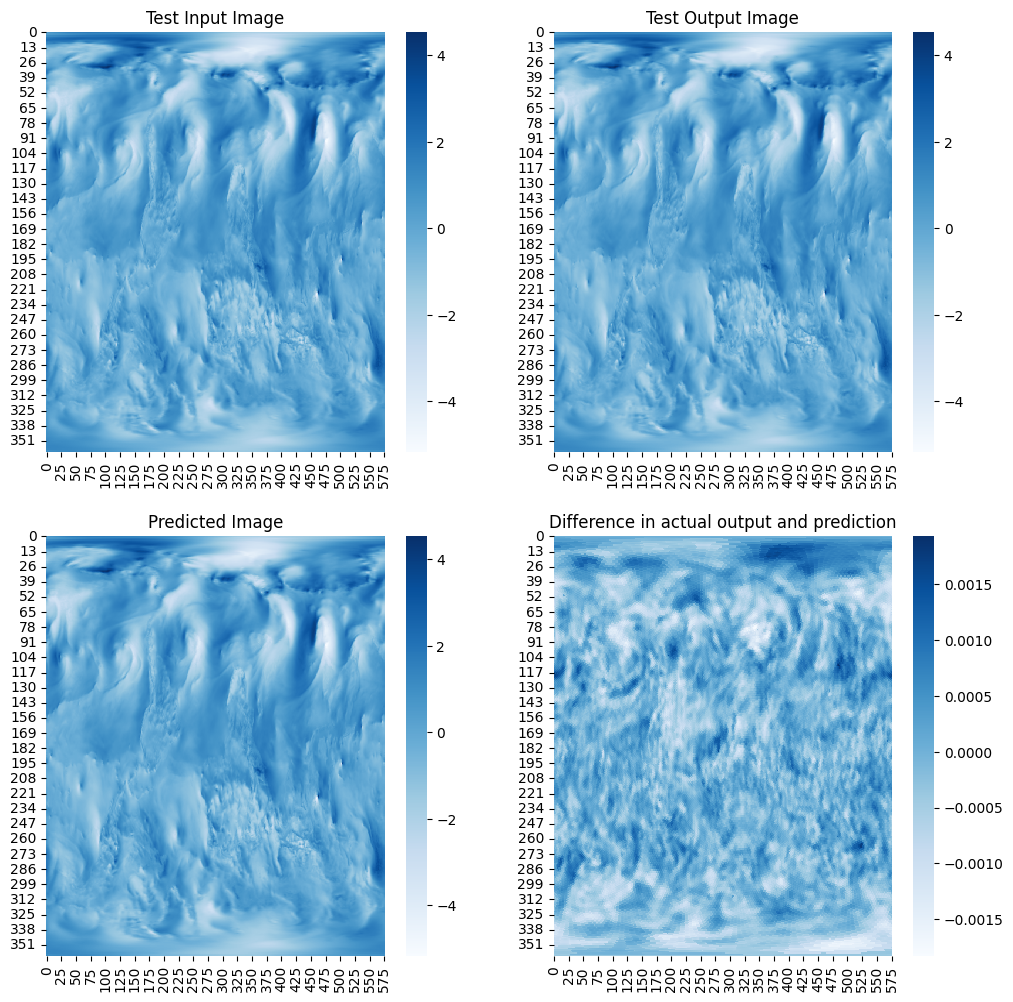

In [46]:
fig1, ax1 = plt.subplots(2, 2, figsize=(12, 12))
sns.heatmap(torch.reshape(inputs, (1, 361, 576, 65))[0, :, :, 64], cbar = True, cmap = 'Blues', ax = ax1[0][0])
ax1[0][0].set_title("Test Input Image")

sns.heatmap(torch.reshape(labels, (1, 361, 576, 65))[0, :, :, 64], cbar = True, cmap = 'Blues', ax = ax1[0][1])
ax1[0][1].set_title("Test Output Image")

sns.heatmap(torch.reshape(outputs_test, (1, 361, 576, 65)).detach().numpy()[0, :, :, 64], cmap = 'Blues', cbar= True, ax = ax1[1][0])
ax1[1][0].set_title("Predicted Image")

sns.heatmap(torch.reshape(diff_test, (1, 361, 576, 65)).detach().numpy()[0, :, :, 64], cmap = 'Blues', cbar = True, ax = ax1[1][1])
ax1[1][1].set_title("Difference in actual output and prediction")

In [ ]:
for name in glob("graph_weather/data/test_data/*.nc", recursive=True):
    dataset = DataLoader(XrDataset(name), batch_size=1)
    fig1, ax1 = plt.subplots(2, 2, figsize=(12, 12))
    fig1.suptitle("Test Image")
    for i, data in tqdm(enumerate(dataset), total=len(dataset), leave=False):
        # get the inputs; data is a list of [inputs, labels]
        inputs_test, labels = data[0].to(device), data[1].to(device)
        ax1[0][0].imshow(torch.reshape(inputs_test, (1, 361, 576, 65))[0, :, :, 27])
        ax1[0][0].set_title("Test Input Image")

        ax1[0][1].imshow(torch.reshape(labels, (1, 361, 576, 65))[0, :, :, 27])
        ax1[0][1].set_title("Test Output Image")
        # zero the parameter gradients
        # forward + backward + optimize
        outputs_test = model(inputs_test)
        ax1[1][0].imshow(
            torch.reshape(outputs_test, (1, 361, 576, 65)).detach().numpy()[0, :, :, 27]
        )
        ax1[1][0].set_title("Predicted Image")

        diff_test = labels - outputs_test

        ax1[1][1].imshow(
            torch.reshape(diff_test, (1, 361, 576, 65)).detach().numpy()[0, :, :, 27]
        )
        ax1[1][1].set_title("Difference in actual output and prediction")

        plt.savefig(f"results_{name.split('/')[-1][:-3]}_{i}_prediction.png")